# Simple convolutional network for MNIST classification

Although CNNs were invented in the 1980s, their breakthrough in the 2000s required fast implementations on graphics processing units (GPUs). The big event was <a href="https://en.wikipedia.org/wiki/AlexNet">AlexNet</a> winning the <a href="https://en.wikipedia.org/wiki/ImageNet#ImageNet_Challenge">ImageNet Large Scale Visual Recognition Challenge</a>.

<img src="https://cms.qz.com/wp-content/uploads/2017/07/image_classification_006.png?quality=75&strip=all&w=1240&h=1602&crop=1" width=600>

In [2]:
import keras
keras.__version__

'2.4.3'

First, let's take a practical look at a very simple convnet example. We will use our convnet to classify MNIST digits, a task that we've already tackled several times, most recently with a feed-forward neural net with several dense layers (our test accuracy then was 97.8%). Even though our convnet here will be very basic, its accuracy will still blow out of the water that of the previous densely-connected model.

The 6 lines of code below show you what a basic convnet looks like. It's a stack of Conv2D and MaxPooling2D layers. We'll see in a minute what they do concretely. Importantly, a convnet takes as input tensors of shape (image_height, image_width, image_channels) (not including the batch dimension). In our case, we will configure our convnet to process inputs of size (28, 28, 1), which is the format of MNIST images (they are grayscale). We do this via passing the argument input_shape=(28, 28, 1) to our first layer.

In [4]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 3, 3, 64)          36928     
Total params: 55,744
Trainable params: 55,744
Non-trainable params: 0
_________________________________________________________________


You can see above that the output of every Conv2D and MaxPooling2D layer is a 3D tensor of shape (height, width, channels). The width and height dimensions tend to shrink as we go deeper in the network. The number of channels is controlled by the first argument passed to the Conv2D layers (e.g. 32 or 64).

The next step would be to feed our last output tensor (of shape (3, 3, 64)) into a densely-connected classifier network like those you are already familiar with: a stack of Dense layers. These classifiers process vectors, which are 1D, whereas our current output is a 3D tensor. So first, we will have to flatten our 3D outputs to 1D, and then add a few Dense layers on top:

In [5]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

We are going to do 10-way classification, so we use a final layer with 10 outputs and a softmax activation. Now here's what our network looks like:

In [6]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense (Dense)                (None, 64)               

As you can see, our (3, 3, 64) outputs were flattened into vectors of shape (576,), before going through two Dense layers. 

In summary, this is what we did so far:

<img src="https://miro.medium.com/max/1400/1*5A4b1qOZIr4Q6SKceqGn7w.jpeg" width=800>

Now, let's train our convnet on the MNIST digits. We will reuse a lot of our previous code.



In [7]:
from keras.datasets import mnist
from keras.utils import to_categorical

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

11493376/11490434 [==============================] - 0s 0us/step


In [8]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=5, batch_size=64)

Epoch 1/5
938/938 [==============================] - 52s 55ms/step - loss: 0.1656 - accuracy: 0.9473
Epoch 2/5
938/938 [==============================] - 52s 55ms/step - loss: 0.0476 - accuracy: 0.9853
Epoch 3/5
938/938 [==============================] - 51s 54ms/step - loss: 0.0324 - accuracy: 0.9900
Epoch 4/5
938/938 [==============================] - 51s 54ms/step - loss: 0.0256 - accuracy: 0.9919
Epoch 5/5
938/938 [==============================] - 52s 55ms/step - loss: 0.0202 - accuracy: 0.9939


Let's evaluate the model on the test data:

In [9]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

313/313 [==============================] - 3s 10ms/step - loss: 0.0256 - accuracy: 0.9920


In [10]:
test_acc

0.9919999837875366

While our previous densely-connected network from had a test accuracy of 97.8%, this basic convnet has a test accuracy of 99.2%: we decreased our error rate by about two-thirds (relative). Not bad!

# Discussion

## Terminology

The fundamental difference between a dense layer and a convolution layer is this:

* **Dense** layers learn global patterns in their feature space; in the case of a MNIST digit, patterns involving **all** pixels (recall the 3Blue1Brown videos).
* **Convolutional** layers learn local patterns; in the case of a MNIST digit, patterns involving a small 2D window of pixels, here 3x3 pixels.

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

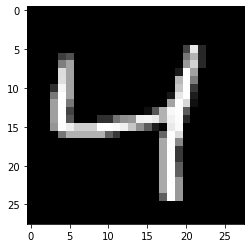

In [16]:
# show one training sample
image = train_images[2]
fig = plt.figure
plt.imshow(image, cmap='gray')
plt.show()

As a result, convolutional networks have two interesting properties:

* **The learned patterns are translation invariant**. Once they learn a pattern appearing in a certain location, e.g., a vertical line, they can recognize it anywhere on the picture. This makes them very efficient for images -- they need fewer training samples in order to learn representations which can generalize easily.
* **They can learn spacial hierarchies of patterns**. The first convolution layer would learn small local patterns such as edges and their shape and orientation (e.g., circle, vertical line, horizontal line). The next will learn larger patterns made of the features learned by the first layer, e.g., cat eye = circle + short vertical line; cat whisker = long horizontal line, cat nose = inverted triangle, etc. The third layer will learn to assemble these into the image of a cat.

Convolution layers operate on 3D tensors, called **feature maps**, with two spatial axes (**height** and **width**) and a **depth** (or **channel**) axis.

* For a **black-and-white image** like the MNIST digits, the depth is 1 (level of gray). 
* For a **color image**, the depth is 3, because the image has 3 color channels (red, green, blue).
* The convolution operation extracts patches from the input feature map, applies the same transformation, and produces an **output feature map**, which is still a 3D tensor with height, width, and depth, but now the depth is a parameter of the layer which indicates the number of applied **filters**.



## The convolution operation

The convolution operation requires an **input dataset** and a convolution **filter** (**kernel**).

<img src="https://miro.medium.com/max/1400/1*cTEp-IvCCUYPTT0QpE3Gjg@2x.png" width=700>

Now place the $n\times n$ filter at each possible location within the $N\times N$ data and compute the tensor product, storing the result in a new array of dimension $(N-n+1)\times (N-n+1)$:

<img src="https://miro.medium.com/max/1400/1*ghaknijNGolaA3DpjvDxfQ@2x.png" width=700>

Here is an animation how this works:

<img src="https://miro.medium.com/max/1400/1*VVvdh-BUKFh2pwDD0kPeRA@2x.gif" width=700>

For color images of shape $(N, N, 3)$ the filter also has a shape of $(n,n,3)$ so that the result of the convolution is still a scalar.

We can now apply a second filter, a third filter, etc. The number of filters is the **output depth** parameter, which is specified by the first argument in layers.Conv2D. An illustration for two different filters:

<img src="https://miro.medium.com/max/1400/1*45GSvnTvpHV0oiRr78dBiw@2x.png" width=700>

## Border effects, padding and stride

### Padding

For any filter at least as large as $2\times 2$, the output layer will be smaller than the input layer, which is due to border effects. This can be avoided by adding **padding** outside the input data frame:

<img src="https://miro.medium.com/max/1400/1*W2D564Gkad9lj3_6t9I2PA@2x.gif" width=700>

### Stride

The stride determines how quickly we move the filter. The default is 1, but we can change it, e.g., to 2:

<img src="https://miro.medium.com/max/1400/1*4wZt9G7W7CchZO-5rVxl5g@2x.gif" width=700>

Notice how the output feature map got smaller.


## The max-pooling operation

Max pooling downsamples the feature maps, reducing their size (similar to **strides**). Max pooling extracts windows from the input feature maps and computes the maximum value found in each one. For example:

<img src="https://miro.medium.com/max/1400/1*ReZNSf_Yr7Q1nqegGirsMQ@2x.png" width=700>

Max pooling is typically done with a $2\times 2$ window, in which case the effect is similar to a convolution with stride 2 and a kernel which is simply the max function.

Max pooling has two goals:

* To allow subsequent layers look at much larger regions of the input data, allowing to learn high level patterns more easily.
* To reduce the number of tunable parameters and thus help with overfitting.



Max pooling is better at downsampling than strides because it is more informative to look at the **maximal** presence of different features than the **average** presence of those features.

Further reading and figure credits: <a href="https://towardsdatascience.com/applied-deep-learning-part-4-convolutional-neural-networks-584bc134c1e2">Applied Deep Learning - Part 4: Convolutional Neural Networks</a>